In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle, islice
import weightedcalcs as wc

# This line lets us plot on our ipython notebook
%matplotlib inline

In [2]:
#Load data
df_15 = pd.read_table("proj_data/ss15hpa_1yr.csv", sep=',', low_memory=False)

#preview first 5 records...
df_15.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp71,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80
0,H,26,2,2600,1,42,1000000,1001264,37,1,...,31,37,33,38,12,11,34,36,33,35
1,H,31,2,3403,1,42,1000000,1001264,206,3,...,205,209,56,216,68,224,235,196,369,319
2,H,35,2,3603,1,42,1000000,1001264,30,2,...,54,51,8,38,31,10,31,9,33,10
3,H,44,2,200,1,42,1000000,1001264,47,2,...,53,46,54,74,54,16,39,16,10,43
4,H,52,2,1200,1,42,1000000,1001264,111,3,...,145,219,24,137,106,164,36,99,119,167


In [3]:
df_15.shape

(63762, 235)

In [4]:
print("total columns:", len(df_15.columns))

total columns: 235


In [5]:
df_15['PUMA'].dtype

dtype('int64')

In [7]:
### NOTE PULL IN SMOCP (selected monthly owner costs) -- Note: Use ADJHSG to adjust SMOCP to constant dollars.
### Pull in NP (Number of person records following this housing record) -- I believe this is right one for determining the poverty guideline...
### Pull in TYPE (type of unit) OR BLD (units in strcuture?)

In [6]:
#too many columns! let's do something about it... 
#get relevant columns: SERIALNO, ST, PUMA, ADJHSG, ADJINC, WGTP, NP, TEN (tenure), BLD, BDSP (# bedrooms), RNTP (rent), VACS (vacancy status),
#...HINCP (hh income), SMOCP (selected monthly owner costs), GRNTP (gross rent), GRPIP (gross rent as % of hh inc), 
#... KIT (complete kitchen), OCPIP (selected monthly owner costs as % hh inc), PLM (complete plumbing) 
df_15_s= df_15[['SERIALNO','ST', 'PUMA', 'ADJHSG', 'WGTP', 'NP', 'TEN', 'BLD', 'BDSP', 'RNTP', 'VACS','HINCP','SMOCP','GRNTP', 'GRPIP','OCPIP', 'KIT', 'PLM']]

df_15_s.head()

,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,VACS,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM
0,26,42,2600,1000000,37,1,3.0,2.0,2.0,500.0,NaN,45000.0,NaN,603.0,16.0,NaN,1.0,1.0
1,31,42,3403,1000000,206,3,3.0,2.0,2.0,800.0,NaN,43300.0,NaN,1147.0,32.0,NaN,1.0,1.0
2,35,42,3603,1000000,30,2,1.0,2.0,4.0,NaN,NaN,125000.0,2090.0,NaN,NaN,20.0,1.0,1.0
3,44,42,200,1000000,47,2,2.0,2.0,3.0,NaN,NaN,96200.0,547.0,NaN,NaN,7.0,1.0,1.0
4,52,42,1200,1000000,111,3,3.0,6.0,2.0,1100.0,NaN,20200.0,NaN,1190.0,71.0,NaN,1.0,1.0


In [7]:
##NOTE there are 5031 records where NP == 0. Reasons why no assoc'd person records? VACS column may shed light
len(df_15_s[df_15_s['NP'] == 0].index)

5031

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f51c860>]], dtype=object)

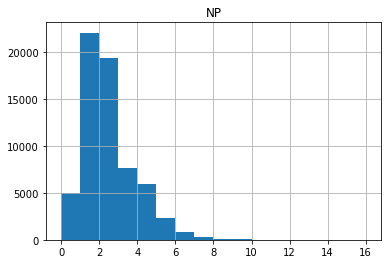

In [8]:
#histogram of distribution of NP (number of person records following this hh)
hh_size = df_15_s.hist(column='NP', bins=16)
hh_size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cc284a8>]], dtype=object)

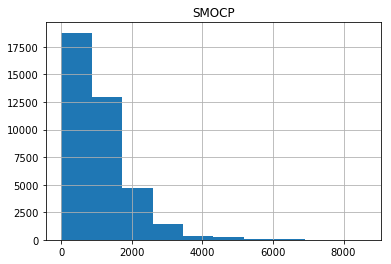

In [9]:
#histogram of distribution of SMOCP 
SMOCP_d = df_15_s.hist(column='SMOCP')
SMOCP_d

In [10]:
#Load poverty guidelines data
pov = pd.read_table("proj_data/pov_guidelines.csv", sep=',', low_memory=False)
pov.head()

,hhd_size,pov_15,pov_14,pov_13,pov_12,pov_11,pov_10,pov_09,pov_08,pov_07,pov_06,pov_05,pov_04,pov_03,pov_02,pov_01,pov_00
0,1,11770.0,11670.0,11490.0,11170.0,10890.00,10830.0,10830.0,10400.0,10210.0,9800.0,9570.0,9310.0,8980.0,8860.0,8590.0,8350.0
1,2,15930.0,15730.0,15510.0,15130.0,"14,710",14570.0,14570.0,14000.0,13690.0,13200.0,12830.0,12490.0,12120.0,11940.0,11610.0,11250.0
2,3,20090.0,19790.0,19530.0,19090.0,"18,530",18310.0,18310.0,17600.0,17170.0,16600.0,16090.0,15670.0,15260.0,15020.0,14630.0,14150.0
3,4,24250.0,23850.0,23550.0,23050.0,"22,350",22050.0,22050.0,21200.0,20650.0,20000.0,19350.0,18850.0,18400.0,18100.0,17650.0,17050.0
4,5,28410.0,27910.0,27570.0,27010.0,"26,170",25790.0,25790.0,24800.0,24130.0,23400.0,22610.0,22030.0,21540.0,21180.0,20670.0,19950.0


In [11]:
#check datatypes to see if join is possible...
print('pov hhd_size:', pov['hhd_size'].dtype, "\n",'pums_np:', df_15_s['NP'].dtype) 


pov hhd_size: int64 
 pums_np: int64


## Merge poverty data to pums

In [12]:
#pull out pov_ 15
pov15=pov.iloc[:,[0,1]]

#merge poverty data to pums
df15_pov = df_15_s.merge(pov15, left_on='NP', right_on='hhd_size')

#let's check that it worked by checking a record, SERIALNO 31
df15_pov[df15_pov['SERIALNO']==31]

,SERIALNO,ST,PUMA,ADJHSG,WGTP,NP,TEN,BLD,BDSP,RNTP,VACS,HINCP,SMOCP,GRNTP,GRPIP,OCPIP,KIT,PLM,hhd_size,pov_15
22105,31,42,3403,1000000,206,3,3.0,2.0,2.0,800.0,NaN,43300.0,NaN,1147.0,32.0,NaN,1.0,1.0,3,20090.0


## Filter for RENTER records we want... 

In [13]:
# r is for renters...
df15_r = df15_pov[df15_pov['GRPIP'].notnull()] 
print("PA rental households in data w/ grpip info:", len(df15_r.index))


PA rental households in data w/ grpip info: 11144


In [14]:
#alternatively, can look at data where tenure = rented (TEN: 1=owned w/ mortgage/loan, 2=owned free & clear, 3=rented, 4=occupied w/o rent)
df15_r = df15_pov[df15_pov['TEN']==3] 
print("PA rental households in data where tenure = rented:", len(df15_r.index))


PA rental households in data where tenure = rented: 11388


In [15]:
# renters with complete kitchen and plumbing
df15_rk = df15_r[df15_r['KIT']==1]
df15_rkp = df15_rk[df15_rk['PLM']==1]

print("PA rental households with complete kitchen, plumbing:", len(df15_rkp.index))

PA rental households with complete kitchen, plumbing: 11165


In [17]:
# FILTER for records where hincp is less than poverty guideline
df15r_need = df15_rkp[(df15_rkp['HINCP']<=df15_rkp['pov_15']) & (df15_rkp['GRPIP'].notnull())]

print("PA rental households below fed poverty line:", len(df15r_need.index))

PA rental households below fed poverty line: 2289


## Do some magic (math) to aggregate data at puma

In [18]:
# add weights to calculator
calc = wc.Calculator("WGTP")

#group by PUMA
grp = df15r_need.groupby(["PUMA"])

#calculate weighted average of housing cost burden for ea puma
df15r_need_avg = calc.mean(grp, 'GRPIP')

#calculate weighted median of housing cost burden for ea puma
df15r_need_med = calc.median(grp, 'GRPIP')

#calculate weighted bottom 25th (neediest 25th percentile) quartile
df15r_need_25 = calc.quantile(grp, 'GRPIP', .75)

#COMPARE
print(df15r_need_avg.head(), '\n', df15r_need_med.head(),'\n',df15r_need_25.head())

PUMA
101    56.893162
102    58.530604
200    61.972290
300    58.359240
400    63.191689
dtype: float64 
 PUMA
101    55.0
102    56.0
200    62.0
300    54.0
400    56.0
dtype: float64 
 PUMA
101     70.0
102     67.0
200    101.0
300     77.0
400     91.0
dtype: float64


In [19]:
# export weighted median of rental housing cost burden for ea puma
df15r_need_med.to_csv('15r_need_med.csv')

## Filter for HOMEOWNER records we want... 

In [20]:
# h is for homeowners...
df15_h = df15_pov[df15_pov['OCPIP'].notnull()] 
print("PA homeowning households in data w/ ocpip info:", len(df15_h.index))

PA homeowning households in data w/ ocpip info: 38228


In [23]:
#alternatively, can look at data where tenure = owned (TEN: 1=owned w/ mortgage/loan, 2=owned free & clear, 3=rented, 4=occupied w/o rent)
df15_h = df15_pov[(df15_pov['TEN']==1) | (df15_pov['TEN']==2)] 
print("PA homeowning households in data where tenure = owned w/ mortgage/loan or owned free & clear:", len(df15_h.index))

PA homeowning households in data where tenure = owned w/ mortgage/loan or owned free & clear: 38471


In [24]:
# homeowners with complete kitchen and plumbing
df15_hk = df15_h[df15_h['KIT']==1]
df15_hkp = df15_hk[df15_hk['PLM']==1]

print("PA homeowning households with complete kitchen, plumbing:", len(df15_hkp.index))

PA homeowning households with complete kitchen, plumbing: 38280


In [25]:
# FILTER for records where hincp is less than poverty guideline
df15h_need = df15_hkp[(df15_hkp['HINCP']<=df15_hkp['pov_15']) & (df15_hkp['OCPIP'].notnull())]

print("PA homeowning households below fed poverty line:", len(df15h_need.index))

PA homeowning households below fed poverty line: 1887


## Do some magic (math) to aggregate data at puma

In [26]:
# add weights to calculator
calc = wc.Calculator("WGTP")

#group by PUMA
grp = df15h_need.groupby(["PUMA"])

#calculate weighted average of housing cost burden for ea puma
df15h_need_avg = calc.mean(grp, 'OCPIP')

#calculate weighted median of housing cost burden for ea puma
df15h_need_med = calc.median(grp, 'OCPIP')

#calculate weighted bottom 25th (neediest 25th percentile) quartile
df15h_need_25 = calc.quantile(grp, 'OCPIP', .75)

#COMPARE
print(df15h_need_avg.head(), '\n', df15h_need_med.head(),'\n',df15h_need_25.head())

PUMA
101    73.897104
102    63.848123
200    55.316951
300    61.539722
400    55.092964
dtype: float64 
 PUMA
101    93.0
102    63.0
200    55.0
300    51.0
400    51.0
dtype: float64 
 PUMA
101    101.0
102     71.0
200     80.0
300    101.0
400     82.0
dtype: float64


In [27]:
# export weighted median of homeowner housing cost burden for ea puma
df15h_need_med.to_csv('15h_need_med.csv')

## ignore things below this line for now

In [42]:
#calculate bottom 25th quartile of HH income for ea. PUMA
s_inc25 = calc.quantile(grp,"HINCP", 0.25)

########################### need to rework things below this line
#convert panda series to df
dfinc25= s_inc25.to_frame()

#rename column so we know it refers to income threshold for bottom 25%
dfinc25.columns = ["INC25P"]

#merge with our df containing rental households with complete kitchen and plumbing...
df_15_inc = df_15_rkp.merge(dfinc25, left_on='PUMA', right_index=True)

#check that it worked!
df_15_inc.head()


,SERIALNO,ST,PUMA,ADJHSG,WGTP,BDSP,RNTP,TEN,VACS,HINCP,GRNTP,GRPIP,OCPIP,KIT,PLM,INC25P
0,26,42,2600,1000000,37,2.0,500.0,3.0,NaN,45000.0,603.0,16.0,NaN,1.0,1.0,14800.0
421,10197,42,2600,1000000,166,2.0,500.0,3.0,NaN,15600.0,500.0,38.0,NaN,1.0,1.0,14800.0
795,19014,42,2600,1000000,80,3.0,500.0,3.0,NaN,51000.0,822.0,19.0,NaN,1.0,1.0,14800.0
972,23644,42,2600,1000000,59,3.0,800.0,3.0,NaN,77000.0,1030.0,16.0,NaN,1.0,1.0,14800.0
1573,37732,42,2600,1000000,192,3.0,580.0,3.0,NaN,2400.0,832.0,101.0,NaN,1.0,1.0,14800.0


In [44]:
#filter out rows where household income is below bottom 25th quartile threshold
df_15_bottom25= df_15_inc[(df_15_inc['HINCP']<= df_15_inc['INC25P'])]

df_15_bottom25

,SERIALNO,ST,PUMA,ADJHSG,WGTP,BDSP,RNTP,TEN,VACS,HINCP,GRNTP,GRPIP,OCPIP,KIT,PLM,INC25P
1573,37732,42,2600,1000000,192,3.0,580.0,3.0,NaN,2400.0,832.0,101.0,NaN,1.0,1.0,14800.0
6775,161303,42,2600,1000000,50,2.0,380.0,3.0,NaN,9100.0,400.0,53.0,NaN,1.0,1.0,14800.0
7540,180251,42,2600,1000000,78,3.0,700.0,3.0,NaN,12670.0,1243.0,101.0,NaN,1.0,1.0,14800.0
11325,270883,42,2600,1000000,57,2.0,380.0,3.0,NaN,12000.0,1020.0,101.0,NaN,1.0,1.0,14800.0
15488,367919,42,2600,1000000,108,3.0,1400.0,3.0,NaN,12440.0,1770.0,101.0,NaN,1.0,1.0,14800.0
16046,381095,42,2600,1000000,64,2.0,130.0,3.0,NaN,4600.0,160.0,42.0,NaN,1.0,1.0,14800.0
17589,417068,42,2600,1000000,20,1.0,450.0,3.0,NaN,14800.0,500.0,41.0,NaN,1.0,1.0,14800.0
19872,470886,42,2600,1000000,276,3.0,500.0,3.0,NaN,3400.0,783.0,101.0,NaN,1.0,1.0,14800.0
21902,518556,42,2600,1000000,88,3.0,400.0,3.0,NaN,12000.0,836.0,84.0,NaN,1.0,1.0,14800.0
22011,521089,42,2600,1000000,18,4.0,470.0,3.0,NaN,8000.0,680.0,101.0,NaN,1.0,1.0,14800.0
